# Example 8

In [1]:
from mapper_base import MapperBase
from astropy.io import fits
from astropy.table import Table

import mapper_eBOSS_QSO
import mapper_CMBK
import pyccl as ccl
import numpy as np
import pylab as plt
import pymaster as nmt
import healpy as hp

In [2]:
# Initialize binning scheme with 20 ells per bandpower
nside = 512
nside_mask = 512

ells = []
i = 11.5
while i <= 3 * nside:
    ells.append(round(i))
    #i = i*(1+i/(3 * nside))
    i = i+20*(1+i/240)
    
if ells[-1] <  3 * nside -1:   
    ells.append(3 * nside -1)

print(len(ells))
bands = nmt.NmtBin.from_edges(ells[:-1], ells[1:])
ell_arr = bands.get_effective_ells()

26


In [3]:
NGC_1_config = {'data_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_data-NGC-vDR16.fits'], 
          'random_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_random-NGC-vDR16.fits'],
          'z_edges':[0, 1.5],
          'nside':nside, 'nside_mask': nside_mask, 'mask_name': 'mask_QSO_NGC_1' }

NGC_2_config = {'data_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_data-NGC-vDR16.fits'], 
          'random_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_random-NGC-vDR16.fits'],
          'z_edges':[1.5, 3],
          'nside':nside, 'nside_mask': nside_mask, 'mask_name': 'mask_QSO_NGC_2'  }

SGC_1_config = {'data_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_data-SGC-vDR16.fits'], 
          'random_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_random-SGC-vDR16.fits'],
          'z_edges':[0.01, 1.5],
          'nside':nside, 'nside_mask': nside_mask, 'mask_name': 'mask_QSO_SGC_1' }

SGC_2_config = {'data_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_data-SGC-vDR16.fits'], 
          'random_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_random-SGC-vDR16.fits'],
          'z_edges':[1.5, 3],
          'nside':nside, 'nside_mask': nside_mask, 'mask_name': 'mask_QSO_SGC_1'  }

In [4]:
NGC_1_maps = mapper_eBOSS_QSO.MappereBOSSQSO(NGC_1_config)
NGC_2_maps = mapper_eBOSS_QSO.MappereBOSSQSO(NGC_2_config)
SGC_1_maps = mapper_eBOSS_QSO.MappereBOSSQSO(SGC_1_config)
SGC_2_maps = mapper_eBOSS_QSO.MappereBOSSQSO(SGC_2_config)

In [5]:
def get_cov_wsp(f1, f2):
    cw = nmt.NmtCovarianceWorkspace()
    cw.compute_coupling_coefficients(f1, f2)
    return cw

def get_cov(cl1, cl2, cl3, cl4, cw, wa, wb):
    return  nmt.gaussian_covariance(cw,
                                      0, 0, 0, 0,  # Spins of the 4 fields
                                      cl1,  # TT
                                      cl2,  # TT
                                      cl3,  # TT
                                      cl4,  # TT
                                      wa, wb=wb)

In [6]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)
b_ngc = 2.37*np.ones(200) 
b_sgc = 2.32 *np.ones(200) 

NGC_nz_1 = NGC_1_maps.get_nz()
NGC_nz_2 = NGC_2_maps.get_nz()
SGC_nz_1 = SGC_1_maps.get_nz()
SGC_nz_2 = SGC_2_maps.get_nz()

NGC_z_1 = NGC_nz_1[1]
NGC_dNdz_1 = NGC_nz_1[0]

NGC_z_2 = NGC_nz_2[1]
NGC_dNdz_2 = NGC_nz_2[0]

SGC_z_1 = SGC_nz_1[1]
SGC_dNdz_1 = SGC_nz_1[0]

SGC_z_2 = SGC_nz_2[1]
SGC_dNdz_2 = SGC_nz_2[0]

NGC_quasar1 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(NGC_z_1,NGC_dNdz_1), bias=(NGC_z_1,b_ngc))
NGC_quasar2 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(NGC_z_2,NGC_dNdz_2), bias=(NGC_z_2,b_ngc))
SGC_quasar1 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(SGC_z_1,NGC_dNdz_1), bias=(SGC_z_1,b_sgc))
SGC_quasar2 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(SGC_z_2,NGC_dNdz_2), bias=(SGC_z_2,b_sgc))
CMB_shear = ccl.CMBLensingTracer(cosmo, 1100)

In [7]:
NGC_theory_11 = ccl.angular_cl(cosmo, NGC_quasar1, NGC_quasar1, ell_arr) 
NGC_theory_12 = ccl.angular_cl(cosmo, NGC_quasar1, NGC_quasar2, ell_arr) 
NGC_theory_22 = ccl.angular_cl(cosmo, NGC_quasar2, NGC_quasar2, ell_arr) 
SGC_theory_11 = ccl.angular_cl(cosmo, SGC_quasar1, SGC_quasar1, ell_arr) 
SGC_theory_12 = ccl.angular_cl(cosmo, SGC_quasar1, SGC_quasar2, ell_arr) 
SGC_theory_22 = ccl.angular_cl(cosmo, SGC_quasar2, SGC_quasar2, ell_arr) 

NGC_shear1 = ccl.angular_cl(cosmo, CMB_shear, NGC_quasar1, ell_arr) 
NGC_shear2 = ccl.angular_cl(cosmo, CMB_shear, NGC_quasar2, ell_arr) 
SGC_shear1 = ccl.angular_cl(cosmo, CMB_shear, SGC_quasar1, ell_arr) 
SGC_shear2 = ccl.angular_cl(cosmo, CMB_shear, SGC_quasar2, ell_arr) 

In [8]:
m1 = SGC_1_maps.get_mask()
m2 = SGC_2_maps.get_mask()

In [9]:
f1 = SGC_1_maps.get_nmt_field()
f2 = SGC_2_maps.get_nmt_field()

In [10]:
w_11 = nmt.NmtWorkspace()
w_11.compute_coupling_matrix(f1, f1, bands)
      
w_12 = nmt.NmtWorkspace()
w_12.compute_coupling_matrix(f1, f2, bands)

w_22 = nmt.NmtWorkspace()
w_22.compute_coupling_matrix(f2, f2, bands)

In [11]:
#everything decoupled
nl11 = SGC_1_maps.get_nl_coupled()
nl22 = SGC_2_maps.get_nl_coupled()
nl12 = np.zeros_like(nl11)
nl21 = np.zeros_like(nl11)

In [12]:
cw_1111 = get_cov_wsp(f1, f1)
cw_1212 = get_cov_wsp(f1, f2)
cw_2222 = get_cov_wsp(f2, f2)

In [13]:
cl = nmt.compute_coupled_cell(f1, f1)/ np.mean(m1 * m1)
cov_11 = get_cov(cl, cl, cl, cl, cw_1111, w_11, w_11)

cl11 = nmt.compute_coupled_cell(f1, f1)/ np.mean(m1 * m1)
cl12 = nmt.compute_coupled_cell(f1, f2)/ np.mean(m1 * m2)
cl21 = nmt.compute_coupled_cell(f2, f1)/ np.mean(m2 * m1)
cl22 = nmt.compute_coupled_cell(f2, f2)/ np.mean(m2 * m2)
cov_12 = get_cov(cl11, cl12, cl21, cl22, cw_1212, w_11, w_22)

cl = nmt.compute_coupled_cell(f2, f2)/ np.mean(m2 * m2)
cov_22 = get_cov(cl, cl, cl, cl, cw_2222, w_22, w_22)

In [14]:
def cov_test(cla1b1, cla2b2, cla1b2, cla2b1, ell_arr, maska, maskb):
    #fsky = np.mean(maska * maskb)
    print('old fsky:', np.mean(maska * maskb))
    mask_bin = np.zeros_like(maska)
    mask_bin[maska>0] = 1 
    fsky = np.mean(mask_bin)
    print('new fsky:', fsky)
    #dl = np.abs(np.roll(ell_arr, 1) - ell_arr)
    dl = np.diff(ells)
    
    #dl[0] = ell_arr[0]
    
    return (cla1b1[0] * cla2b2[0] + cla1b2[0] * cla2b1[0]) / (fsky * (2 * ell_arr + 1) * dl)
    

In [15]:
err_11 = np.sqrt(cov_11.diagonal())
err_12 = np.sqrt(cov_12.diagonal())
err_22 = np.sqrt(cov_22.diagonal())

cl11 = w_11.decouple_cell(nmt.compute_coupled_cell(f1, f1))
alt_err_11 = np.sqrt(cov_test(cl11, cl11, cl11, cl11, ell_arr, m1, m1))

#The cov doesn't have dimensions of [3*nside, 3*nside] but of [bands, bands]
#due to the presence of w_11 which was made of bands
#to match the errors to the fid Cl, I have had to revaluate them a

old fsky: 0.009531140909100275
new fsky: 0.04937171936035156


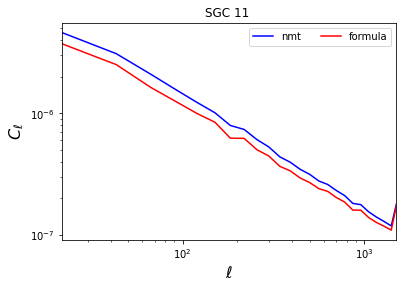

In [16]:
plt.plot(ell_arr, err_11, 'b', label='nmt')
plt.plot(ell_arr, alt_err_11, 'r', label='formula')
#plt.plot(ell_arr, alt2_err_11[0], 'g', label='formula')


plt.loglog()
plt.xlim((ell_arr[0], ell_arr[-1]))
plt.title('SGC 11 ')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()

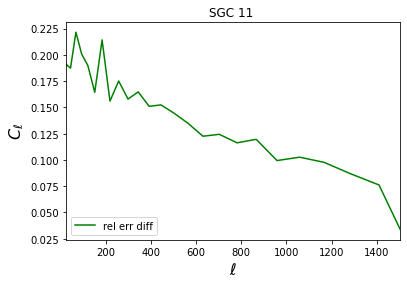

In [17]:
plt.plot(ell_arr, np.abs(err_11 - alt_err_11)/err_11, 'g', label='rel err diff')


#plt.loglog()
plt.xlim((ell_arr[0], ell_arr[-1]))
plt.title('SGC 11 ')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

In [18]:
cl11 = w_11.decouple_cell(nmt.compute_coupled_cell(f1, f1))-w_11.decouple_cell(nl11)
cl12 = w_12.decouple_cell(nmt.compute_coupled_cell(f1, f2))
cl22 = w_22.decouple_cell(nmt.compute_coupled_cell(f2, f2))-w_11.decouple_cell(nl22)

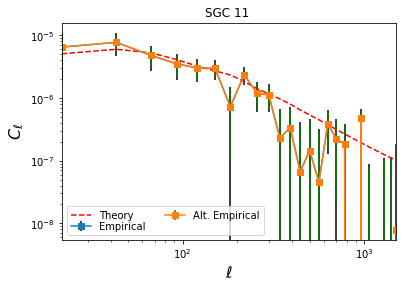

In [19]:
plt.errorbar(ell_arr, cl11[0], yerr=err_11, marker='s', ecolor='k', label='Empirical')
plt.errorbar(ell_arr, cl11[0], yerr=alt_err_11, marker='s', ecolor='g', label='Alt. Empirical')
plt.plot(ell_arr, SGC_theory_11, 'r--', label='Theory')


plt.loglog()
plt.xlim((ell_arr[0], ell_arr[-1]))
plt.title('SGC 11 ')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

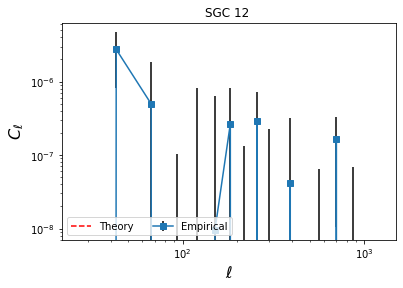

In [20]:
plt.errorbar(ell_arr, cl12[0], yerr=err_12, marker='s', ecolor='k', label='Empirical')#, 'r-', label='Data')
plt.plot(ell_arr, SGC_theory_12, 'r--', label='Theory')


plt.loglog()
plt.xlim((ell_arr[0], ell_arr[-1]))
plt.title('SGC 12 ')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

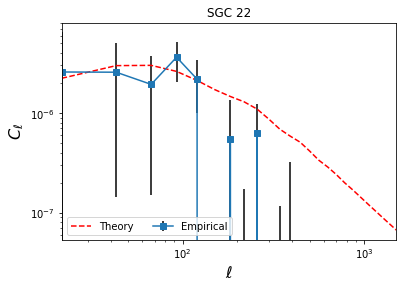

In [21]:
plt.errorbar(ell_arr, cl22[0], yerr=err_22, marker='s', ecolor='k', label='Empirical')#, 'r-', label='Data')
plt.plot(ell_arr, SGC_theory_22, 'r--', label='Theory')


plt.loglog()
plt.xlim((ell_arr[0], ell_arr[-1]))
plt.title('SGC 22')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

In [22]:
CMBK_config = {'file_klm':'/home/zcapjru/PhD/Data/COM_Lensing_2048_R2.00/dat_klm.fits', 
          'file_mask':'/home/zcapjru/PhD/Data/COM_Lensing_2048_R2.00/mask.fits.gz',
               'file_noise':'/home/zcapjru/PhD/Data/COM_Lensing_2048_R2.00/nlkk.dat', 'mask_name': 3,
          'nside':nside}

In [23]:
CMBK_maps = mapper_CMBK.MapperCMBK(CMBK_config)
mk = CMBK_maps.get_mask()
signalk = CMBK_maps.get_signal_map()

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma

In [24]:
fk = CMBK_maps.get_nmt_field()
f1 = SGC_1_maps.get_nmt_field()
f2 = SGC_2_maps.get_nmt_field()

In [25]:
w_k1 = nmt.NmtWorkspace()
w_k1.compute_coupling_matrix(f1, fk, bands)

w_k2 = nmt.NmtWorkspace()
w_k2.compute_coupling_matrix(f2, fk, bands)

w_kk = nmt.NmtWorkspace()
w_kk.compute_coupling_matrix(fk, fk, bands)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [26]:
cw_1k1k = get_cov_wsp(f1, fk)
cw_2k2k = get_cov_wsp(f2, fk)

In [27]:
cl11 = nmt.compute_coupled_cell(f1, f1)/ np.mean(m1 * m1)
cl1k = nmt.compute_coupled_cell(f1, fk)/ np.mean(m1 * mk)
clk1 = nmt.compute_coupled_cell(fk, f1)/ np.mean(mk * m1)
clkk = nmt.compute_coupled_cell(fk, fk)/ np.mean(mk * mk)
cov_1k = get_cov(cl11, cl1k, clk1, clkk, cw_1k1k, w_11, w_kk)

cl22 = nmt.compute_coupled_cell(f2, f2)/ np.mean(m2 * m2)
cl2k = nmt.compute_coupled_cell(f2, fk)/ np.mean(m2 * mk)
clk2 = nmt.compute_coupled_cell(fk, f2)/ np.mean(mk * m2)
clkk = nmt.compute_coupled_cell(fk, fk)/ np.mean(mk * mk)
cov_2k = get_cov(cl22, cl2k, clk2, clkk, cw_2k2k, w_22, w_kk)

In [28]:
cl1k = w_k1.decouple_cell(nmt.compute_coupled_cell(f1, fk))
cl2k = w_k2.decouple_cell(nmt.compute_coupled_cell(f2, fk))

In [29]:
err_1k = np.sqrt(cov_1k.diagonal())
err_2k = np.sqrt(cov_2k.diagonal())

In [30]:
print(err_1k)

[1.38749734e-07 9.17366652e-08 6.61110071e-08 5.07383620e-08
 4.21457021e-08 3.49044336e-08 3.01038458e-08 2.86871246e-08
 2.61592314e-08 2.46162978e-08 2.17864260e-08 1.96726448e-08
 1.73110631e-08 1.60507374e-08 1.49580056e-08 1.47868400e-08
 1.39678678e-08 1.34512984e-08 1.25998795e-08 1.27177711e-08
 1.19941454e-08 1.36023154e-08 1.45560075e-08 1.44389464e-08
 2.32559903e-08]


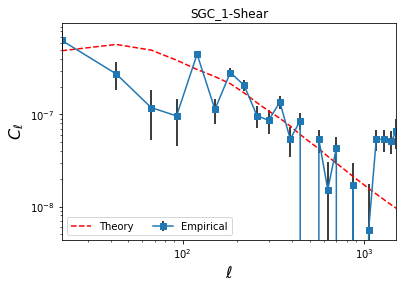

In [31]:
plt.errorbar(ell_arr, cl1k[0], yerr=err_1k, marker='s', ecolor='k', label='Empirical')
plt.plot(ell_arr, SGC_shear1, 'r--', label='Theory')


plt.loglog()
plt.xlim((ell_arr[0], ell_arr[-1]))
plt.title('SGC_1-Shear')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

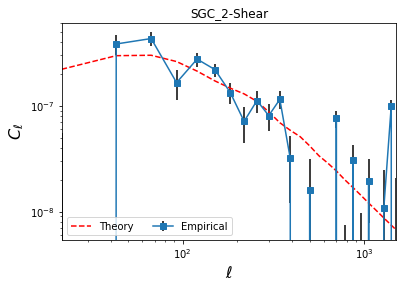

In [32]:
plt.errorbar(ell_arr, cl2k[0], yerr=err_2k, marker='s', ecolor='k', label='Empirical')
plt.plot(ell_arr, SGC_shear2, 'r--', label='Theory')


plt.loglog()
plt.xlim((ell_arr[0], ell_arr[-1]))
plt.title('SGC_2-Shear')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()